In [1]:
# activate package, basic imports + load data
include("/Users/federicoclaudi/Documents/Github/LocomotionControl/analysis/behavior/analysis_fixtures.jl")
include("/Users/federicoclaudi/Documents/Github/LocomotionControl/analysis/behavior/analysis_visuals.jl")
using Dierckx

import jcontrol: State, movingaverage

  Activating project at `~/Documents/Github/LocomotionControl/analysis/behavior`


@Info (Main):  Loaded 1021 trials 
  ╰──────────────────────────────────────────────── 


                      Fri, 13 May 2022 23:07:46 
@Info (Main):  After tortuosity analysis, discarded 9.109% of trials | 928

 
  │                trials left 
  ╰──────────────────────────────────────────────── 
                      Fri, 13 May 2022 23:07:49 


## Artificial dataset
Simple artificial dataset created from the global MTM solution.

In [6]:
# load global solution
gsol_path = "/Users/federicoclaudi/Dropbox (UCL)/Rotation_vte/Locomotion/analysis/behavior/globalsolution.csv"
globalsolution = DataFrame(CSV.File(gsol_path))
solution =  Solution((df2sol ∘ fix_solution_dtype)(globalsolution));

parameters

In [79]:
n_trials = 100
N_samples_per_trial = 128
Δs = 5  # distance between sampling's of the track's curvature
S = 50   # lookahead distance for track's curvature.

time_stamps = rand(1:(length(solution.t)-N_samples_per_trial-1), n_trials)
nothing

get dataset entries

In [12]:
struct DatasetEntry
    n::Vector{Float64}
    ψ::Vector{Float64}
    s::Vector{Float64}
    V::Vector{Float64}
    ω::Vector{Float64}
    V̇::Vector{Float64}
    ω̇::Vector{Float64}
    k::Matrix{Float64}   # stores the curvature at each waypoint and each frame
end

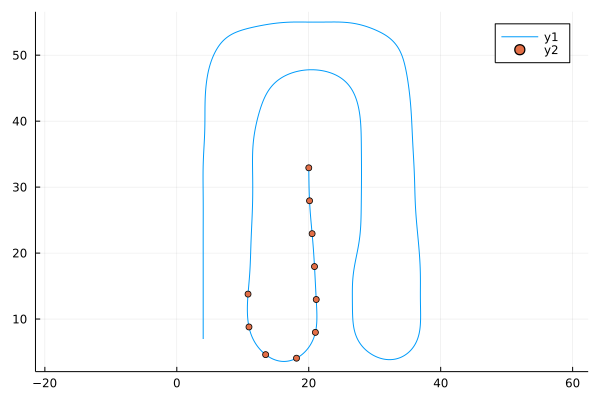

In [61]:
"""
Given an s-value, returns a set of indexes to access the track's variables at equally spaced
points along the track.

"""
function get_track_waypoints(sval)
    ds = FULLTRACK.S .- sval
    idxs = findall(
        (diff(mod.(ds, Δs)) .<= 0) .* (ds .>= 0)[2:end] .* (ds .<= S)[2:end],
    )
    return [argmin(ds.^2), idxs...]
end
# track = Track(; resolution=0.01)

# plot(diff(track.S))
track_idxs = get_track_waypoints(0)
plot(FULLTRACK.X, FULLTRACK.Y)
scatter!(FULLTRACK.X[track_idxs], FULLTRACK.Y[track_idxs]; aspect_ratio=:equal)

In [80]:
waypoints = collect(0:Δs:S)
waypoints_idxs = 1:length(waypoints)

V = sqrt.(solution.v .^ 2 + solution.u .^ 2)
V̇ = [0, diff(V)...]
ω̇ = [0, diff(solution.ω)...]

entries = []
for ts in time_stamps
    if solution.s[ts + N_samples_per_trial] + S > 240
        continue
    end

   # get curvature
   curv = zeros(length(waypoints_idxs), N_samples_per_trial)


   for frame in 1:N_samples_per_trial
        s = solution.s[ts + frame]
        idxs = get_track_waypoints(s)

        @assert length(idxs) == length(waypoints_idxs)  "$(length(idxs)) $(length(waypoints_idxs)) $ts $frame $s"
        curv[:, frame] = FULLTRACK.curvature[idxs]
   end

   push!(entries, DatasetEntry(
        solution.n[ts:ts+N_samples_per_trial-1],
        solution.ψ[ts:ts+N_samples_per_trial-1],
        solution.s[ts:ts+N_samples_per_trial-1],
        V[ts:ts+N_samples_per_trial-1],
        solution.ω[ts:ts+N_samples_per_trial-1],
        V̇[ts:ts+N_samples_per_trial-1],
        ω̇[ts:ts+N_samples_per_trial-1],
        curv,
    )
    )
end

#### Save data

In [76]:
length(entries)

63

In [75]:
using JSON: JSON
using DataFrames: DataFrame
import JSONTables: objecttable, jsontable
import OrderedCollections: OrderedDict

savepath = "/Users/federicoclaudi/Dropbox (UCL)/Rotation_vte/Locomotion/analysis/RNN/artificial_dataset"

for (i, entry) in enumerate(entries)
    ks = collect(Symbol("k_", i)=>entry.k[i, :] for i in 1:size(entry.k,1 ))
    dict = OrderedDict{Symbol, Union{Vector{Float64}, Matrix{Float64}}}(
        :n=>entry.n,
        :ψ=>entry.ψ,
        :s=>entry.s,
        :V=>entry.V,
        :ω=>entry.ω,
        :v̇=>entry.V̇,
        :ω̇=>entry.ω̇,
        ks...
    )
    df = DataFrame(dict)

    open(joinpath(savepath, "$(i).json"), "w") do f
        write(f, objecttable(df))
    end
end